#### *ISEL - DEI - LEIM*
## Aprendizagem Automática [T52D]
### Trabalho Laboratorial 2: Classificação de Críticas de Cinema do IMDb

João Madeira ($48630$), 
Renata Góis ($51038$),
Bruno Pereira ($51811$)

**Docentes responsáveis:** 
- Prof. Gonçalo Xufre Silva

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as p
import re
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
import sklearn.preprocessing as pp
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from resources.methods import class_stats, reg_stats, cluster_top_words, cluster_metrics

In [16]:
with open("resources/imdbFull.p", "rb") as f:
    D = p.load(f)
print("Keys:", D.keys())

reviews = D['data']
sentiments = D['target']

print(len(reviews), "reviews")

Keys: dict_keys(['data', 'target', 'DESCR'])
50000 reviews


This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.
For more details see: http://ai.stanford.edu/~amaas/data/sentiment/

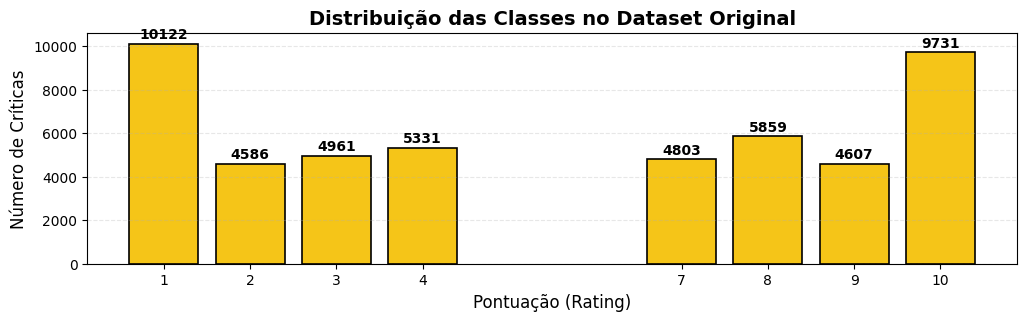

Classificações Negativas (1-4): 25000
Classificações Positivas (7-10): 25000


In [17]:
unique, counts = np.unique(sentiments, return_counts=True)

plt.figure(figsize=(12, 3))
bars = plt.bar(unique, counts, color='#f5c518', edgecolor='black', linewidth=1.2)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, int(yval), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Pontuação (Rating)', fontsize=12)
plt.ylabel('Número de Críticas', fontsize=12)
plt.title('Distribuição das Classes no Dataset Original', fontsize=14, fontweight='bold')
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()
print(f"Classificações Negativas (1-4): {sum(counts[:4])}")
print(f"Classificações Positivas (7-10): {sum(counts[4:])}")

<center><h1><b>1.</b></h1></center>
<center><h4><b>Construção do Vocabulário</b></h4></center>

***

O objetivo desta etapa foi reduzir o ruído e a dimensionalidade do vocabulário, mantendo o conteúdo semântico relevante.

**Stemming:** Aplicou-se o algoritmo `SnowballStemmer` para reduzir as palavras à sua raiz lexical, permitindo agrupar variações da mesma palavra.

In [18]:
stemmer = SnowballStemmer("english")

def clean_review(string):
    # Remove tags HTML
    string = string.replace('<br />', ' ')  
    # Remove palavras com 20 ou mais caracteres
    string = re.sub(r'\b[a-zA-Z]{20,}\b', ' ', string)
    # Remove palavras com 3 ou mais letras repetidas consecutivamente (e.g., "yaaass", "omgggg")
    string = re.sub(r'\b\w*(.)\1{2,}\w*\b', ' ', string)
    # Filtra apenas letras
    string = re.sub(r'[^a-zA-Z]', ' ', string)
    # Remove espaços consecutivos
    string = re.sub(r'\s+', ' ', string).strip()
    # Normaliza para minúsculas
    string = string.lower()
    # Aplica Stemming
    string = " ".join(stemmer.stem(w) for w in string.split())
    return string

reviews = [clean_review(rev) for rev in reviews]

output = {"data" : reviews, "target" : sentiments}
p.dump(output,open("resources/imdbPreProcessed.p",'wb'))

A representação numérica foi gerada com o `TfidfVectorizer`. 

<span style="color:teal"><b>STOPWORDS:</b></span> Personalizou-se a lista de **stopwords** para manter explicitamente termos de negação ("*no*", "*not*", "*nor*"). A remoção destes termos inverteria a polaridade de expressões atípicas (*ex:* a remoção de "*not*" em "*not good*" alteraria o sentido para "*good*").
- **N-grams (1,2):** Configurou-se a extração de *unigramas* e *bigramas* para capturar esse contexto local (ex: "*not good*").

Definiram-se `min_df=3` e `max_features=30k` para eliminar erros ortográficos pontuais e controlar o uso de memória.

In [19]:
custom_stopwords = list(ENGLISH_STOP_WORDS - {'no', 'not', 'nor'})

tfidfVector = TfidfVectorizer(min_df=3,                    # Remove palavras que aparecem menos de 10 vezes no dataset
                        max_df=0.8,                        # Remove palavras que aparecem em 90% do dataset 
                        max_features=30000,                # Limita o maximo de features para 30.000
                        ngram_range=(1,2),                 # Utiliza unigramas e bigramas (good, very good, pretty bad)
                        token_pattern=r'\b[a-zA-Z]{2,}\b', # Ignora palavras com menos de 2 letras
                        sublinear_tf=True,                 # Term frequency passa a ter um comportamento logarítmico em vez de linear
                        stop_words=custom_stopwords        # Remove stopwords em inglês excepto "no", "not" e "nor"
                        )

In [20]:
pre_processed_data = p.load(open("resources/imdbPreProcessed.p","rb"))
reviews = pre_processed_data['data']
sentiments = pre_processed_data['target']

tfidfVector = tfidfVector.fit(reviews)

tokens = tfidfVector.get_feature_names_out()
X = tfidfVector.transform(reviews)
# X.astype(np.float32) # reduz para metade a utilização de RAM
len(tokens)

30000

<div style="background-color: #de989eff; color: #82222bff; border: 1px solid #f5c6cb; padding: 15px; border-radius: 5px; margin-bottom: 15px;">
  <center><h5><b>Notas sobre a Estrutura do Relatório</b></h5></center>
  Para promover uma leitura mais fluida do relatório:
  <ul>
    <li><strong>Foram unidas as secções propostas <i>2</i> e <i>3</i>.</strong> A apresentação dos modelos (Classificação/Regressão) é feita em conjunto com a respetiva indicação de métricas e metodologias de teste.</li>
    <li><strong>Modularização de Código.</strong> As funções auxiliares para cálculo de métricas, conversão de escalas e geração de gráficos comparativos foram extraídas para o módulo externo <code>resources/methods.py</code>. 
    <li><strong>Análise.</strong> A análise de resultados foi colocada no final do relatório (secção <i>4</i>).</li>
  </ul>
</div>

<center><h1><b>2.</b></h1></center>
<center><h4><b>Classificação e Regressão</b></h4></center>

***
Para ambas as tarefas, utilizou-se a mesma matriz `TF-IDF` construída anteriormente, garantindo comparabilidade entre as abordagens.

#### **2.1.** Divisão em conjuntos de treino, teste e validação
Realizou-se a partição do *dataset* em três subconjuntos: **treino**, **teste** e **validação**. Utilizou-se amostragem estratificada (`stratify`) para garantir que a distribuição original das classes de *rating* fosse preservada proporcionalmente em todos os subconjuntos.

<br>
<div align="center">

| Treino | Teste | Validação |
| :---: | :---: | :---: |
| 40 000 (80%) | 5 000 (10%) | 5 000 (10%) |

</div>


In [21]:
# Split 80% treino / 20% temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, sentiments,
    test_size=0.2,
    random_state=42,
    stratify=sentiments
)

# Split 50% validação, 50% teste (10% / 10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

#### **2.2.** Modelos de Classificação
Optou-se por testar os modelos `LogisticRegression`, `LinearSVC` e `RandomForest`.

##### **2.2.1.** `LogisticRegression`

**Otimização:** Efetuou-se uma pesquisa em grelha (`GridSearchCV`) com validação cruzada (`cv=3`) para determinar o valor ideal do parâmetro de regularização `C`.

**Regularização:** Manteve-se a penalização L2 para mitigar o risco de *overfitting*.

In [22]:
param_grid = {
    'penalty': ['l2'],
    'solver': ['saga'],
    'C': [1, 2, 5],
    'max_iter': [50,100]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42, n_jobs=1), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'saga'}


In [23]:
lr = LogisticRegression(penalty='l2', solver='saga', C=1, max_iter=50, random_state=42)
lr = lr.fit(X_train, y_train)

In [24]:
predicted_lrtest = lr.predict(X_test)
class_stats(y_test, predicted_lrtest, "Conjunto de Teste")

Conjunto de Teste
Accuracy: 43.34 %
Precision: 34.84 %
Recall: 34.03 %
Matriz de confusão : 
 [[826  51  48  37   7   6   4  33]
 [276  31  49  65  10  11   2  15]
 [201  22  79 108  19  22   7  38]
 [138  23  69 161  47  28   7  60]
 [ 27   4  12  45 123 116  19 134]
 [ 20   2   8  29 105 159  20 243]
 [ 13   1   5  10  40  83  35 274]
 [ 44   2   7  10  33  93  31 753]]


In [25]:
predicted_lrval = lr.predict(X_val)
class_stats(y_val, predicted_lrval, "Conjunto de Validação")

Conjunto de Validação
Accuracy: 43.46 %
Precision: 34.71 %
Recall: 34.25 %
Matriz de confusão : 
 [[815  38  45  53   5  11   4  41]
 [263  36  42  73  10   9   2  23]
 [183  40  83 117  22  20   7  24]
 [123  22  83 181  47  26   7  44]
 [ 25   7  20  43 126 109  19 132]
 [ 26   3  10  26 106 127  34 254]
 [ 11   3   7   7  36  86  38 273]
 [ 32   3   3  17  31  89  31 767]]


##### **2.2.2.** `LinearSVC`

In [26]:
param_grid = {
    'C': [0.1, 1, 2, 5],
    'max_iter': [2000, 5000, 10000]
}

grid_search = GridSearchCV(LinearSVC(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 0.1, 'max_iter': 2000}


In [27]:
lsvc = LinearSVC(random_state=42, C=0.1, max_iter=2000)
lsvc = lsvc.fit(X_train, y_train)

In [28]:
predicted_svctest = lsvc.predict(X_test)
class_stats(y_test, predicted_svctest,"Conjunto de Teste")

Conjunto de Teste
Accuracy: 43.06 %
Precision: 34.17 %
Recall: 32.65 %
Matriz de confusão : 
 [[871  26  29  32   6   7   3  38]
 [309  22  33  51  11  10   2  21]
 [229  21  57  98  21  18   4  48]
 [171  18  58 144  39  25   8  70]
 [ 29   3  13  42 111 106  15 161]
 [ 26   0   6  28  92 127  13 294]
 [ 17   0   1  10  37  61  23 312]
 [ 48   1   5   9  28  66  18 798]]


In [29]:
predicted_svcval = lsvc.predict(X_val)
class_stats(y_val, predicted_svcval,"Conjunto de Validação")

Conjunto de Validação
Accuracy: 43.62 %
Precision: 33.83 %
Recall: 33.29 %
Matriz de confusão : 
 [[868  24  25  37   3  10   3  42]
 [310  19  26  58  10   6   1  28]
 [231  24  63 109  18  14   5  32]
 [155  16  61 173  45  21   8  54]
 [ 31   6  16  40 117 106   8 157]
 [ 28   3   9  23  94 118  23 288]
 [ 15   2   6  11  28  70  19 310]
 [ 35   1   3  14  28  68  20 804]]


##### **2.2.3.** `RandomForestClassifier`

In [30]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None],
    "min_samples_split": [2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
# Não foi possivel obter um resultado com o Grid Search

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [31]:
rfc = RandomForestClassifier(random_state=42, n_estimators= 200, max_depth= None, min_samples_split= 2)
rfc = rfc.fit(X_train, y_train)

In [32]:
predicted_rfctest = rfc.predict(X_test)
class_stats(y_test, predicted_rfctest,"Conjunto de Teste")

Conjunto de Teste
Accuracy: 38.28 %
Precision: 51.95 %
Recall: 25.46 %
Matriz de confusão : 
 [[918   0   2   6   1   2   0  83]
 [385   5   1   6   0   6   0  56]
 [339   0  14  13   8   8   0 114]
 [308   1   6  34  11  17   0 156]
 [ 94   0   2  15  28  43   0 298]
 [ 77   0   1   6  15  38   0 449]
 [ 42   0   1   2   7  20   2 387]
 [ 73   0   0   2   4  19   0 875]]


In [33]:
predicted_rfcval = rfc.predict(X_val)
class_stats(y_val, predicted_rfcval,"Conjunto de Validação")

Conjunto de Validação
Accuracy: 38.52 %
Precision: 53.35 %
Recall: 25.82 %
Matriz de confusão : 
 [[925   0   1   5   0   2   0  79]
 [365   6   2  10   1   5   0  69]
 [356   0  17  22   2   9   0  90]
 [325   0   9  36   9  16   0 138]
 [ 90   0   0  12  28  56   0 295]
 [ 93   0   0   7  17  46   1 422]
 [ 35   0   0   1   8  19   7 391]
 [ 83   0   0   1   8  20   0 861]]


#### **2.3.** Modelos de Regressão
Na abordagem de regressão, o objetivo foi prever a pontuação como um **valor contínuo**. 

Foram avaliados o `Lasso`, `Ridge` e `GradientBoostingRegressor`.

<div style="border: 1px solid #ccc; padding: 15px; border-radius: 5px;">

**Conversão para Classes (<span style="color:lightblue"><i>Mapeamento</i></span>):** Para comparar a regressão com a classificação, foi necessário converter as previsões contínuas ($y_{pred}$) em classes discretas $\{1..4, 7..10\}$. 

Implementou-se a seguinte lógica de pós-processamento:
1. **Arredondamento:** Os valores previstos foram arredondados para o número inteiro mais próximo. Como as classes $5$ e $6$ não existem no *dataset*, previsões arredondadas para $5$ foram mapeadas para $4$, e previsões de $6$ mapeadas para $7$.
2. **Limites:** Valores inferiores a $1$ ou superiores a $10$ foram truncados para os limites da escala.

</div>

##### **2.3.1.** `Lasso`

In [34]:
param_grid = {
    "alpha": [0.001,1], 
    "max_iter": [40, 50]
}

grid_search = GridSearchCV(Lasso(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'alpha': 0.001, 'max_iter': 40}


In [35]:
lasso = Lasso(alpha = 0.001, max_iter=40, random_state=42)
lasso.fit(X_train,y_train)

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,40
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [36]:
predicted_lassotest = lasso.predict(X_test)
reg_stats(y_test,predicted_lassotest,"Conjunto de Teste")

Conjunto de Teste
erro quadrático absoluto : 1.97
erro quadratico medio : 5.6
R2 : 0.54
Accuracy: 21.18 %
Matriz de confusão :
 [[164 177 193 382  89   6   0   1]
 [ 42  54  84 211  63   4   1   0]
 [ 28  32  83 230 118   4   1   0]
 [ 11  31  48 236 194  11   2   0]
 [  0   2   2  91 296  73  12   4]
 [  0   0   2  76 333  99  57  19]
 [  0   0   0  34 222 123  59  23]
 [  0   1   1  72 424 256 151  68]]


In [37]:
predicted_lassoval = lasso.predict(X_val)
reg_stats(y_val,predicted_lassoval,"Conjunto de Validação")

Conjunto de Validação
erro quadrático absoluto : 1.94
erro quadratico medio : 5.48
R2 : 0.55
Accuracy: 21.94 %
Matriz de confusão :
 [[178 159 212 363  98   1   1   0]
 [ 44  53  78 210  73   0   0   0]
 [ 15  38  68 273  96   6   0   0]
 [ 14  21  65 263 161   8   1   0]
 [  0   2   1 108 280  67  21   2]
 [  0   1   1  76 329 122  44  13]
 [  0   0   0  36 224 128  54  19]
 [  0   1   3  73 441 246 130  79]]


##### **2.3.2.** `Ridge`

In [38]:
param_grid = {
    "alpha" : [1, 2, 3],
    "max_iter" : [50, 100, 500],
    'solver': ['lsqr', 'sparse_cg', 'sag', 'auto']
}

grid_search = GridSearchCV(Ridge(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'alpha': 2, 'max_iter': 50, 'solver': 'sparse_cg'}


In [39]:
ridge = Ridge(alpha = 2, max_iter=50, solver="sparse_cg", random_state=42)
ridge.fit(X_train,y_train)

,alpha,2
,fit_intercept,True
,copy_X,True
,max_iter,50
,tol,0.0001
,solver,'sparse_cg'
,positive,False
,random_state,42


In [40]:
predicted_ridgetest = ridge.predict(X_test)
reg_stats(y_test,predicted_ridgetest,"Conjunto de Teste")

Conjunto de Teste
erro quadrático absoluto : 1.62
erro quadratico medio : 4.12
R2 : 0.66
Accuracy: 27.02 %
Matriz de confusão :
 [[250 233 224 259  44   1   1   0]
 [ 67  84 111 166  27   3   1   0]
 [ 49  58 102 205  78   4   0   0]
 [ 20  46  78 249 125  11   4   0]
 [  0   3   4  65 269  82  47  10]
 [  0   0   2  39 271 121 106  47]
 [  0   0   1  26 153 127  96  58]
 [  0   2   1  45 280 239 226 180]]


In [41]:
predicted_ridgeval = ridge.predict(X_val)
reg_stats(y_val,predicted_ridgeval,"Conjunto de Validação")

Conjunto de Validação
erro quadrático absoluto : 1.61
erro quadratico medio : 4.02
R2 : 0.67
Accuracy: 27.88 %
Matriz de confusão :
 [[268 205 254 235  45   3   1   1]
 [ 66  83 111 167  29   2   0   0]
 [ 40  55 116 227  52   5   1   0]
 [ 18  42  88 265 107  10   3   0]
 [  0   1   2  92 243  87  47   9]
 [  0   0   2  50 270 135  86  43]
 [  0   0   1  20 141 139 108  52]
 [  0   2   3  47 287 242 216 176]]


##### **2.3.3.** `GradientBoostingRegressor`

In [42]:
param_grid = {
    "n_estimators": [100],
    "learning_rate": [0.05],
    "max_depth": [3,4],
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid,cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}


In [43]:
gbr = GradientBoostingRegressor(n_estimators = 100, learning_rate=0.05, max_depth=4, random_state=42)
gbr.fit(X_train,y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


In [44]:
predicted_gbrtest = gbr.predict(X_test)
reg_stats(y_test,predicted_gbrtest,"Conjunto de Teste")

Conjunto de Teste
erro quadrático absoluto : 2.21
erro quadratico medio : 6.72
R2 : 0.44
Accuracy: 16.46 %
Matriz de confusão :
 [[ 44 163 268 373 157   7   0   0]
 [  8  51  93 185 118   4   0   0]
 [  7  33  65 224 163   4   0   0]
 [  0  20  62 222 218  10   1   0]
 [  0   0  10  91 337  39   3   0]
 [  0   0   5  82 397  96   6   0]
 [  0   0   3  37 304 109   8   0]
 [  0   1   6  75 596 261  34   0]]


In [45]:
predicted_gbrval = gbr.predict(X_val)
reg_stats(y_val,predicted_gbrval,"Conjunto de Validação")

Conjunto de Validação
erro quadrático absoluto : 2.22
erro quadratico medio : 6.81
R2 : 0.44
Accuracy: 17.0 %
Matriz de confusão :
 [[ 53 179 252 361 164   3   0   0]
 [ 10  46  91 194 115   2   0   0]
 [  5  18  71 241 157   4   0   0]
 [  1  12  60 239 214   7   0   0]
 [  0   1   7 101 323  47   2   0]
 [  0   2   1  88 383 106   6   0]
 [  0   0   4  43 295 107  12   0]
 [  0   0   6  89 615 240  23   0]]


<center><h1><b>3.</b></h1></center>
<center><h4><b><i>Clustering</i></b></h4></center>

***

Nesta etapa, agruparam-se críticas com base na similaridade semântica dos seus vetores **TF-IDF**. O algoritmo escolhido foi o **K-Means**.

<center><b>Número de <i>Clusters</i> = <code>2</code></b></center>

In [46]:
km2clusters = KMeans(n_clusters=2, random_state=42, n_init=10)
km2cLabels = km2clusters.fit_predict(X)



Cluster 1 top 20 words:
movi | not | like | watch | just | bad | film | good | realli | don | make | time | no | think | act | onli | becaus | look | peopl | thing | 

Cluster 2 top 20 words:
film | not | movi | stori | veri | charact | time | like | great | love | make | play | good | just | onli | scene | life | perform | no | best | 
Silhouette score (amostrado): 0.0015778078825863884 

Cluster 1  nº críticas: 21888
Cluster 2  nº críticas: 28112


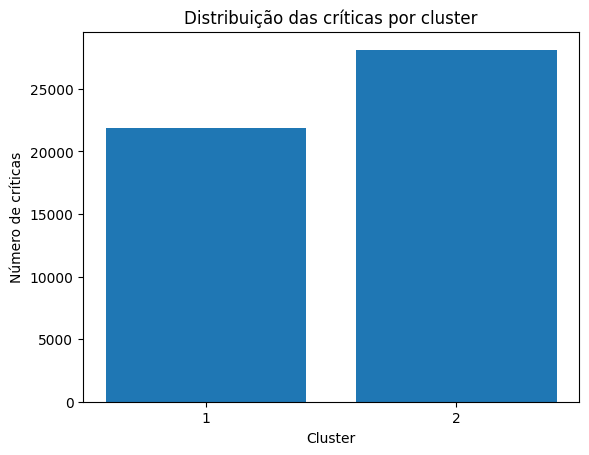

In [47]:
cluster_top_words(tfidfVector,km2clusters,20)
cluster_metrics(X,km2cLabels,sample_size=5000)

<center><b>Número de <i>Clusters</i> = <code>4</code></b></center>

Efetuaram-se testes com $4$ *clusters*, no entanto, através das mais frequentes $20$ palavras, não foi possivel fazer uma avaliação significante. No máximo, seria possível averiguar vagamente quais eram os *clusters* positivos e negativos, à semelhança com o teste anterior.

<center><b>Número de <i>Clusters</i> = <code>8</code></b></center>

In [48]:
km8clusters = KMeans(n_clusters=8, random_state=42, n_init=10)
km8cLabels = km8clusters.fit_predict(X)



Cluster 1 top 20 words:
film | movi | not | like | play | time | good | just | comedi | onli | make | star | scene | look | man | no | veri | charact | best | year | 

Cluster 2 top 20 words:
horror | film | movi | horror movi | horror film | not | gore | like | good | just | realli | make | effect | veri | scene | look | no | watch | budget | bad | 

Cluster 3 top 20 words:
movi | bad | film | not | just | watch | like | act | no | make | don | good | time | wast | realli | plot | onli | look | thing | worst | 

Cluster 4 top 20 words:
episod | seri | season | tv | watch | like | not | charact | just | time | veri | good | great | realli | love | onli | best | end | new | stori | 

Cluster 5 top 20 words:
film | stori | not | veri | charact | great | perform | movi | love | time | beauti | make | like | good | actor | life | best | act | work | play | 

Cluster 6 top 20 words:
ve seen | ve | seen | movi | film | movi ve | worst | not | like | time | watch | just | bad | good | reall

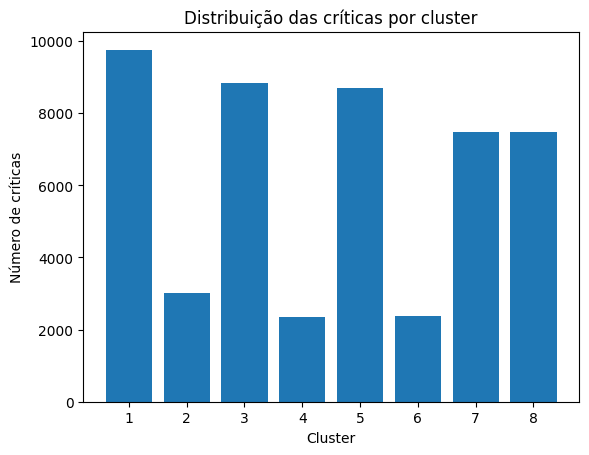

In [49]:
cluster_top_words(tfidfVector,km8clusters,20)
cluster_metrics(X,km8cLabels)

<center><b>Número de <i>Clusters</i> = <code>20</code></b></center>

In [50]:
km20clusters = KMeans(n_clusters=20, random_state=42, n_init=10)
km20cLabels = km20clusters.fit_predict(X)



Cluster 1 top 20 words:
school | high school | high | movi | film | student | like | not | watch | girl | just | make | good | time | kid | play | year | bad | friend | teacher | 

Cluster 2 top 20 words:
funni | comedi | laugh | movi | not | joke | like | film | just | watch | veri | good | time | realli | make | humor | don | think | charact | hilari | 

Cluster 3 top 20 words:
film | not | like | just | movi | charact | no | make | scene | realli | time | look | thing | becaus | end | onli | know | don | ani | way | 

Cluster 4 top 20 words:
war | film | world war | soldier | world | movi | not | german | american | stori | time | dure | like | veri | battl | no | scene | make | just | onli | 

Cluster 5 top 20 words:
horror | horror movi | film | movi | horror film | not | gore | like | good | just | make | realli | veri | effect | watch | no | scene | look | fan | budget | 

Cluster 6 top 20 words:
bad | movi | act | worst | watch | not | just | film | like | bad movi | good | m

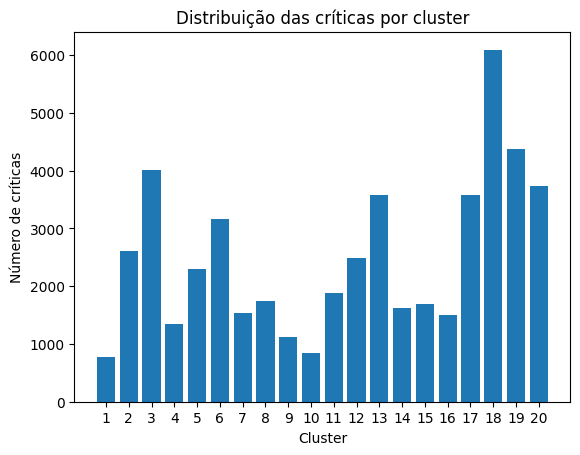

In [51]:
cluster_top_words(tfidfVector,km20clusters,20)
cluster_metrics(X,km20cLabels)

<center><b>Número de <i>Clusters</i> = <code>25</code></b></center>

In [52]:
km25clusters = KMeans(n_clusters=25, random_state=42, n_init=10)
km25cLabels = km25clusters.fit_predict(X)



Cluster 1 top 20 words:
special effect | special | effect | movi | film | bad | not | act | good | like | look | just | watch | plot | make | no | stori | veri | time | realli | 

Cluster 2 top 20 words:
music | song | danc | sing | film | movi | number | not | love | like | band | great | play | time | perform | singer | just | good | rock | stage | 

Cluster 3 top 20 words:
ve seen | ve | seen | movi | movi ve | film | worst | not | like | just | watch | time | bad | film ve | worst movi | good | realli | act | don | think | 

Cluster 4 top 20 words:
episod | seri | season | watch | tv | charact | like | not | just | time | good | veri | end | great | best | realli | stori | everi | onli | televis | 

Cluster 5 top 20 words:
film | not | charact | veri | stori | like | movi | good | plot | watch | make | just | scene | realli | no | act | end | time | onli | ani | 

Cluster 6 top 20 words:
funni | comedi | laugh | movi | joke | not | like | film | just | veri | watch | good | time 

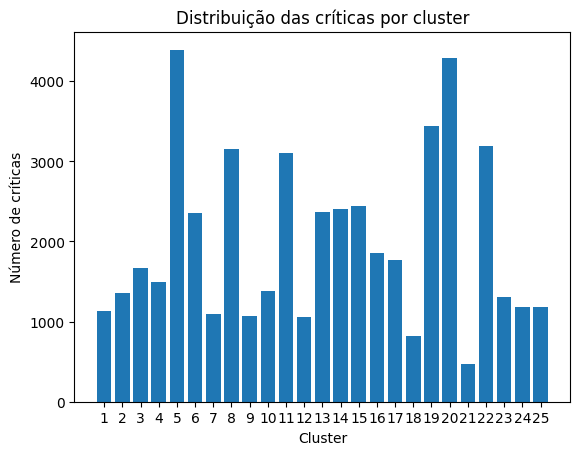

In [53]:
cluster_top_words(tfidfVector,km25clusters,20)
cluster_metrics(X,km25cLabels)

<center><h1><b>4.</b></h1></center>
<center><h4><b>Resultados</b></h4></center>

***

### **4.1.** Classificação

| Métrica | `LogisticRegression` | `LinearSVC` |
| :--- | ---: | ---: |
| *Accuracy* | 43.14% 🟠 | **43.74%** 🟢 |
| *Precision* | **34.60%** 🟢 | 34.45% 🔴 |
| *Recall* | **34.08%** 🟢 | 33.50% 🔴 |

Observa-se um "empate técnico" entre os dois modelos lineares. O `LinearSVC` destaca-se ligeiramente na métrica principal, *Accuracy*, revelando-se mais eficaz na decisão final da classe correta. 

Já o `LogisticRegression`, embora acerte menos vezes no total, demonstra ser ligeiramente mais consistente na forma como lida com cada nota individualmente, cometendo erros que penalizam menos as métricas de qualidade por classe (*Precision*/*Recall*)."

<span style="color:red"><b>Desqualificado:</b></span> O <code>RandomForestClassifier</code> foi descartado devido ao seu elevado custo computacional e clara incapacidade de superar os restantes modelos lineares.

### **4.2.** Regressão
| Métrica | `Lasso` | `Ridge` | `GradientBoosting` |
| :--- | ---: | ---: | ---: |
| *Accuracy* | 22.10% 🟡 | **27.86%** 🟢 | 17.20% 🔴 |
| *MSE* | 5.49  🟡 | **4.03** 🟢 | 6.81 🔴 |
| *$R^2$ Score* | 0.55  🟡 | **0.67** 🟢 | 0.44 🔴 |

Na regressão, verifica-se uma distinção clara na capacidade de adaptação dos modelos à esparsidade dos dados textuais.

O regressor **`Ridge`** obteve as métricas mais positivas. A regularização L2 do `Ridge` revelou-se mais eficaz do que a seleção de características do `Lasso` (L1), sugerindo que o sentimento é melhor explicado pela combinação ponderada de múltiplas palavras do que pela seleção restrita de alguns termos-chave.

<span style="color:darkred"><b>Limitações</span> observadas no <code>GradientBoosting</code>:</b> 

Este regressor registou o desempenho mais baixo ($R^2$* de $0.44$). Este resultado evidencia a dificuldade dos **modelos baseados em árvores** de decisão em lidar com matrizes de alta dimensionalidade ($30.000$ *features*) sem uma redução prévia de dimensionalidade, contrastando com a eficiência dos **modelos lineares** neste contexto.

**O $R^2$ indica a proporção da variância da variável alvo que é explicada pelo modelo. Varia idealmente entre $0$ e $1$, onde $1$ representa um ajustamento perfeito aos dados e $0$ equivale a prever sempre a média.*

### **4.3.** Clustering

O *clustering* não supervisionado (algoritmo `KMeans`) foi realizado com diferentes valores de $k$ para analisar a estrutura dos dados. A interpretação dos *clusters* baseou-se na análise das $20$ palavras mais frequentes (centróides) de cada grupo.

<center><h5><b><code>2</code> e <code>4</code> <i>Clusters</i></b></h5></center>


Com um número reduzido de clusters (`2` e `4`), o algoritmo tende a separar as críticas baseando-se na carga emocional das palavras, em vez do conteúdo temático.

$k=2$: Observou-se uma dicotomia clara entre sentimento positivo e sentimento negativo. A variância nos dados é explicada primariamente pelo vocabulário avaliativo (ex: "*bad*", "*worst*" vs. "*great*", "*perfect*"), confirmando a natureza polarizada do *dataset*.

<div align="center">

| Conotação Positiva ($1$) | Conotação Negativa ($2$)|
|:-:|:-: |
| $55.89\%$ | $44.11\%$ |

</div>

$k=4$: A divisão revelou-se ambígua. Os grupos adicionais não apresentaram distinção temática clara, permanecendo variantes de sentimento. Por não acrescentar valor semântico significativo, esta configuração não foi aprofundada.

<center><h5><b><code>8</code> <i>Clusters</i></b></h5></center>

Ao aumentar o número de grupos para $8$, começou-se a observar a transição de "**Sentimento**" para "**Género**". Embora alguns grupos permaneçam indefinidos, surgem os primeiros temas identificáveis:

<div align="center">

| *Cluster* | Tópico Identificado | $\%$ Dados |
| :---: | :--- | :---: |
| **$1$** | Filmes de Comédia | $7.43\%$ |
| **$5$** | Séries de TV | $4.64\%$ |
| **$7$** | Filmes de Terror | $5.73\%$ |
| *Outros* | *Indefinido* | $82.20\%$ |

</div>
<br>

<center><h5><b><code>20</code> <i>Clusters</i></b></h5></center>

Com valores de $k$ mais elevados, o algoritmo conseguiu isolar tópicos muito específicos e géneros cinematográficos distintos.

$k=20$: Notou-se uma fragmentação excessiva, com vários *clusters* a representarem menos de 0.1% dos dados (*ex:* *Clusters* $11$, $13$, $19$). Isto sugere que o algoritmo pode estar a isolar *outliers* ou pequenos *sub-niches* muito específicos.

<div align="center">

| *Cluster* | Tópico Identificado | $\%$ Dados | *Cluster* | Tópico Identificado | $\%$ Dados |
|:---:|:---|:---:|:---:|:---|:---:|
| **$2$** | Filmes Sci-Fi | $1.67\%$ | **$11$** | Filmes de Terror | $0.04\%$ |
| **$4$** | Filmes de Guerra | $2.87\%$ | **$13$** | Filmes de Animação | $0.03\%$ |
| **$5$** | Séries de TV | $3.47%$ | **$19$** | Filmes de Comédia | $0.05\%$ |
| **$6$** | Ação / Artes Marciais | $0.96\%$ | **$20$** | Musicais | $0.03\%$ |
| **$7$** | Filmes de Baixo Orçamento | $2.41\%$ | **$9$** | "Desperdício de Tempo" | $3.12\%$ |

</div>

*(**Nota:** Os clusters $1$, $3$, $8$, $10$, $12$, $14$-$18$ foram classificados como **inconclusivos**, representando a maioria dos dados restantes ($85.35\%$)).*

<center><h5><b><code>25</code> <i>Clusters</i></b></h5></center>

$k=25$: Esta configuração apresentou a melhor distribuição de tópicos, permitindo identificar desde géneros típicos até formatos específicos (*ex.:* Adaptações, Documentários). A tabela abaixo resume os tópicos identificados:

<div align="center">

| *Cluster* | Tópico Identificado | $\%$ Dados | *Cluster* | Tópico Identificado | $\%$ Dados |
|:---:|:---|:---:|:---:|:---|:---:|
| **$1$** | Séries de TV | $3.08\%$ | **$14$** | "Piores Filmes" | $2.77\%$ |
| **$2$** | Filmes Sci-Fi | $1.63\% $| **$16$** | Musicais | $2.53\%$ |
| **$4$** | "Desperdício de tempo" | $2.80\%$ | **$17$** | Adaptações de Livros | $2.24\%$ |
| **$6$** | Filmes de Terror | $4.48\%$ | **$18$** | Filmes Festivos | $0.94\%$ |
| **$7$** | Ação e Artes Marciais | $1.00\%$ | **$20$** | Documentários | 2.68\% |
| **$8$** | Filmes de Família | $4.21\%$ | **$21$** | Adaptações de Videojogos | $1.22\%$ |
| **$10$** | Animação | $2.43\%$ | **$22$** | Guerra | $2.74\%$ |
| **$24$** | Filmes +18 | $2.34\%$ | **$25$** | Comédia | $4.93\%$ |

</div>
<br>

Os clusters não listados foram classificados como **inconclusivos**, representando os dados restantes ($57.98\%$). Observa-se, então,  que o algoritmo conseguiu "resgatar" quase $30\%$ do *dataset* que, em $k=20%$, estava "perdido".